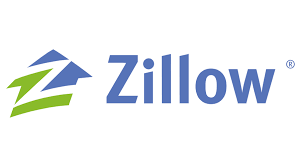

# <center>The Zillow Project<center>

****

## Context
The sector of Real Estate is fluctuating and prices are becoming difficult to predict due to the economic changes we have experienced recently. Zillow, however, to remain competitive must be able to predict property assessment prices in order to make its business model viable.
For that, the data science team need to provide some answers and I have been tasks to provide some of those answers.

## Business Goals
  #### - Construct a Regression model that predict propery assessed values ('taxvaluedollarcnt') of Single Family Properties using attributes of the properties.
  #### - Find the key drivers of property assessed value for single family properties.
  #### - Deliver a report that the data science team can read through and replicate, understand what steps were taken, why and what the outcome was.
  #### -  Make recommendations on what works or doesn't work in prediction these homes' values.

****

## Executive Summary & Conclusions
#### - Need: Be able to predict assessed price based on property features which will help the company's business model
#### - Regression models were used (OLS, LassoLars, & Tweedie Regressor)
#### - Findings:

* The best model in my case is the LassoLars Model.
    
<font color = 'brown'>**Its RMSE is $$491,929.37 compared to the baseline at $602,948.58 which rrepresents an improvment by lowering error by 18.41%**</font>

* Some features drive assessed values more than other:
    - indoor_sqft
    - then bathrooms and bedrooms
    - This may suggest that clients are interested in size of course but most importantly amenities in the bathrooms but I am not categorical on that


* The relationship between the independent variables and the dependent one is not very strong hinting to the fact that there are probably more elements to that relationship

****

In [188]:
# Imports necessary for the notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import math
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

import os
import wrangle
from env import host, user, password

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# I. Acquiring the data for preparation

At this point I have created a function <font color = 'brown'>get_connection</font> that uses login info from env.py file to access Codeup database.

It returns a string that can be used in another function <font color = 'brown'>wrangle_zillow</font> to return a dataframe from the SQL database

In [2]:
# Getting the file

properties_2017 = wrangle.wrangle_zillow()

****

# II. Cleaning and Preparing the data

* Main question: What can prevent me from having data without nulls, that is relevant to my modeling, that is compatible with my models?
* Plan
    - Check for null values and drop them if they are not in great numbers (for example more than 10% of the data. This will also depend on the size of the data)
    - Check for hard to read columns names to rename them appropriately
    - Check for irrelevant columns (that won't impact the analysis and the modeling) and drop them
    - Check for incompatible data types (example: data should be int64 but is object or float)
    - Do a univariate exploration through charts and columns observation

## A. General examination of the data, the columns, rows, and entries

In [3]:
# Displaying the dataframe to take a look at it

properties_2017.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,propertylandusetypeid,transactiondate
0,4.0,3.5,3100.0,1023282.0,261.0,2017-01-01
1,2.0,1.0,1465.0,464000.0,261.0,2017-01-01
2,3.0,2.0,1243.0,564778.0,261.0,2017-01-01
3,4.0,3.0,2376.0,145143.0,261.0,2017-01-01
4,4.0,3.0,2962.0,773303.0,261.0,2017-01-01


In [4]:
# Getting information about number of coulumns, number of rows data type, size of the file (for pushing to github)

properties_2017.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52442 entries, 0 to 52441
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52442 non-null  float64
 1   bathroomcnt                   52442 non-null  float64
 2   calculatedfinishedsquarefeet  52360 non-null  float64
 3   taxvaluedollarcnt             52441 non-null  float64
 4   propertylandusetypeid         52442 non-null  float64
 5   transactiondate               52442 non-null  object 
dtypes: float64(5), object(1)
memory usage: 2.8+ MB


In [6]:
# Getting the proportion of null values in the data

round(properties_2017.isnull().mean(), 4)

bedroomcnt                      0.0000
bathroomcnt                     0.0000
calculatedfinishedsquarefeet    0.0016
taxvaluedollarcnt               0.0000
propertylandusetypeid           0.0000
transactiondate                 0.0000
dtype: float64

In [7]:
# Displaying the count of each value innthe columns of properties_2017

for column in properties_2017.columns:
    print(column)
    print(properties_2017[column].value_counts())
    print('\n##########################\n')

bedroomcnt
3.0     23360
4.0     15240
2.0      8340
5.0      3973
6.0       635
1.0       612
0.0       137
7.0       106
8.0        24
9.0         8
12.0        3
10.0        2
14.0        1
11.0        1
Name: bedroomcnt, dtype: int64

##########################

bathroomcnt
2.0     21894
3.0     10673
1.0      9568
2.5      3934
4.0      2227
3.5       918
1.5       841
5.0       803
4.5       687
6.0       322
5.5       224
0.0       121
7.0        88
8.0        53
6.5        47
7.5        16
9.0        13
10.0        5
11.0        3
8.5         3
18.0        1
13.0        1
Name: bathroomcnt, dtype: int64

##########################

calculatedfinishedsquarefeet
1120.0    128
1200.0    119
1080.0    102
1040.0     86
936.0      86
         ... 
7088.0      1
604.0       1
5422.0      1
534.0       1
5655.0      1
Name: calculatedfinishedsquarefeet, Length: 4723, dtype: int64

##########################

taxvaluedollarcnt
455000.0    34
600000.0    30
550000.0    24
500000.0    24

### Takeaways
#### * Observations
    - There are very few null values
    - The column names are hard to read
    - There are no numbers behind the comma of bedroomcnt, calculatedfinishedsquarefeet, and taxvaluedollarcnt
    - The transactiondate is an object type, cannot be scaled
#### * Actions
    - Drop null values and transactiondate which is not needed for the MVP
    - The propertylandusetypeid column can be dropped. It is an identifier for the type of house I am working on
    - Convert bedroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, and transactiondate to int
    - Leave bathroomcnt as is
    - Rename columns
    - Move to univariate exploration

## B. Preforming Actions planned in previous step

In [9]:
# Dropping the null values and reassigning properties_2017 to houses

houses = properties_2017.dropna(axis = 0, how ='any')

In [10]:
# Calculating the percentage of null values dropped

print("Properties_2017 length:", len(properties_2017), "\nHouses length:", 
       len(houses), "\nPercentage of rows with at least 1 NA value dropped: ",
       round(((len(properties_2017)-len(houses))/len(properties_2017))*100, 2))

Properties_2017 length: 52442 
Houses length: 52359 
Percentage of rows with at least 1 NA value dropped:  0.16


In [11]:
# Dropping the transactiondate column

houses = houses.drop(['transactiondate'], axis = 1)
houses.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,propertylandusetypeid
0,4.0,3.5,3100.0,1023282.0,261.0
1,2.0,1.0,1465.0,464000.0,261.0
2,3.0,2.0,1243.0,564778.0,261.0
3,4.0,3.0,2376.0,145143.0,261.0
4,4.0,3.0,2962.0,773303.0,261.0


In [12]:
# Dropping the propertylandusetypeid column

houses = houses.drop(['propertylandusetypeid'], axis = 1)
houses.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt
0,4.0,3.5,3100.0,1023282.0
1,2.0,1.0,1465.0,464000.0
2,3.0,2.0,1243.0,564778.0
3,4.0,3.0,2376.0,145143.0
4,4.0,3.0,2962.0,773303.0


In [13]:
# Renaming columns

cols_to_rename = {
    'calculatedfinishedsquarefeet': 'indoor_sqft',
    'taxvaluedollarcnt': 'tax_value',
    'bedroomcnt': 'bedrooms',
    'bathroomcnt': 'bathrooms',
}

houses = houses.rename(columns=cols_to_rename)
houses.head()

,bedrooms,bathrooms,indoor_sqft,tax_value
0,4.0,3.5,3100.0,1023282.0
1,2.0,1.0,1465.0,464000.0
2,3.0,2.0,1243.0,564778.0
3,4.0,3.0,2376.0,145143.0
4,4.0,3.0,2962.0,773303.0


In [14]:
# Transforming data types to int then I can scale it

houses['bedrooms'] = houses['bedrooms'].astype(int)
houses['indoor_sqft'] = houses['indoor_sqft'].astype(int)
houses['tax_value'] = houses['tax_value'].astype(int)

houses.head()

,bedrooms,bathrooms,indoor_sqft,tax_value
0,4,3.5,3100,1023282
1,2,1.0,1465,464000
2,3,2.0,1243,564778
3,4,3.0,2376,145143
4,4,3.0,2962,773303


In [15]:
# Checking the data types

houses.dtypes

bedrooms         int64
bathrooms      float64
indoor_sqft      int64
tax_value        int64
dtype: object

### Conclusion: 
**The data is already cleaner at this point but the univariate observation is going to help me find drivers and understand the direction my Exploration should take**

## C. Univariate observation of the data to set it up for eploration

In [17]:
# Running a .describe() function to have a first statistical look at the data

houses.describe().T.astype('int64')

,count,mean,std,min,25%,50%,75%,max
bedrooms,52359,3,0,0,3,3,4,14
bathrooms,52359,2,1,0,2,2,3,18
indoor_sqft,52359,1922,1004,128,1268,1659,2306,21929
tax_value,52359,528020,748323,1000,193644,373374,618531,49061236


### Takeaways of .describe()
* Observations
    - The max values are high compared to min values in all columns (given their nature bedrooms and bathrooms)
    - The values seem to relate to each other proportionally
* To-dos
    - Use graphs to visualize the structure of the data

bedrooms


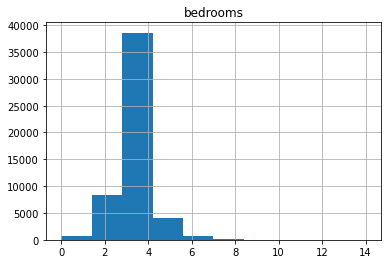

bathrooms


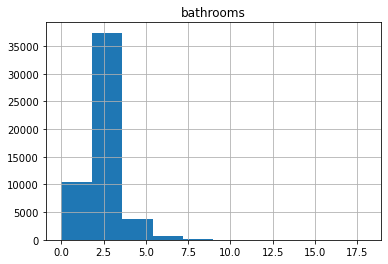

indoor_sqft


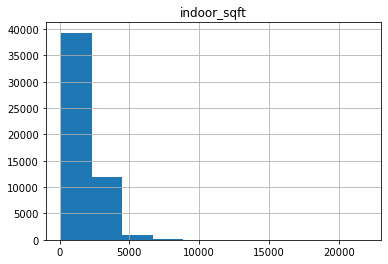

tax_value


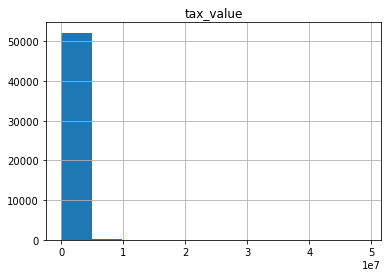

In [18]:
# Using a for loop to plot columns to observe outliers

for column in houses.columns:
    print(column)
    plt.title(column)
    houses[column].hist()
    plt.grid(True)
    plt.show()

### Takeaways of histograms

**A first look shows me that there may be a lot of outliers because of the length of the x axis**

**The value still seem to be connected becase of the shape of the bars except for tax_value where it is not obvious**

<font color = 'brown'>**An observation with boxplots and countplots will give me a better view of the data**</font>

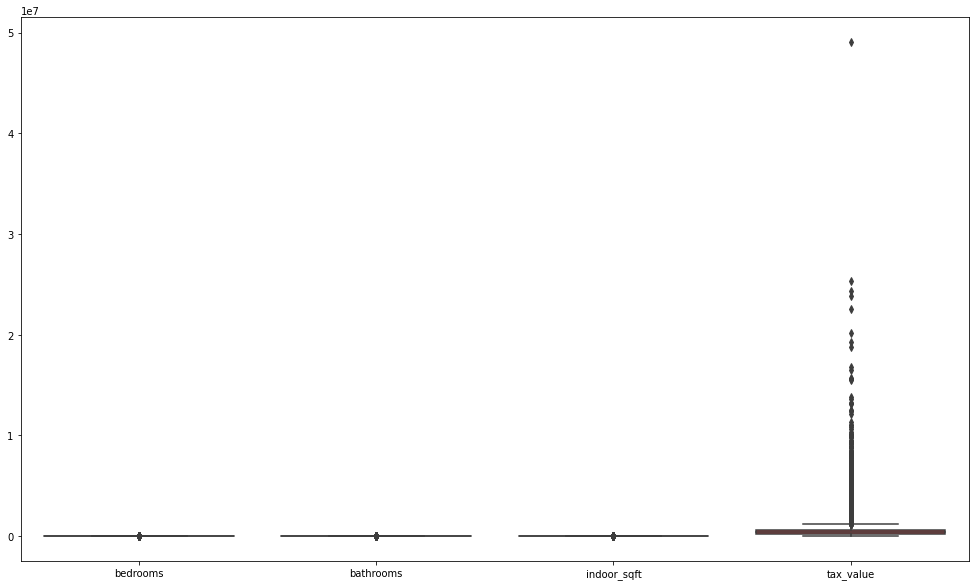

In [19]:
# Plotting a boxplot of all columns to have a better view

plt.figure(figsize=(17,10))
sns.boxplot(data=houses)
plt.show()

**Values are very different between tax_value and the others**


**I will plot them separately to havea better view**

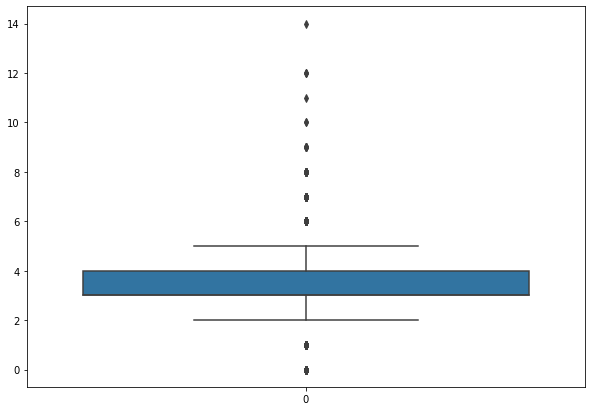

In [20]:
# Plotting data using a boxplot to understand distribution and see outliers

plt.figure(figsize=(10,7))
sns.boxplot(data=houses.bedrooms)
plt.show()

# There are lots of outliers

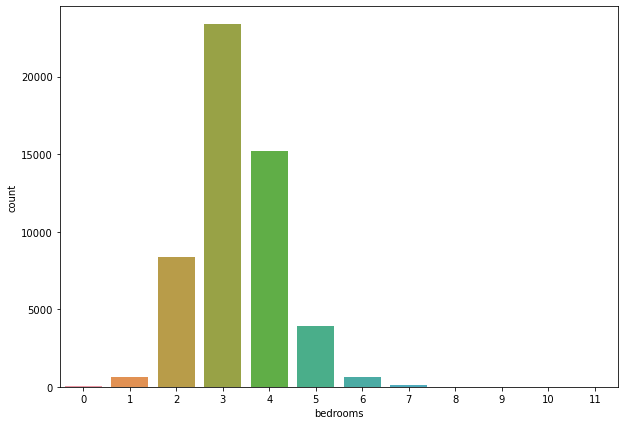

In [49]:
# Using a countplot to further investigate the distribution of the data

plt.figure(figsize=(10,7))
sns.countplot(x='bedrooms', data=houses)
plt.show()

**The bedrooms columns is surprisingly pretty normally distributed**

**It contains a great number of outliers**

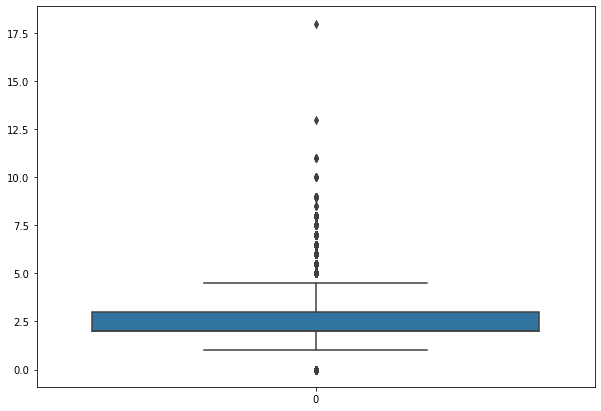

In [21]:
# Plotting data using a boxplot to understand distribution and see outliers

plt.figure(figsize=(10,7))
sns.boxplot(data=houses.bathrooms)
plt.show()

# There are lots of outliers

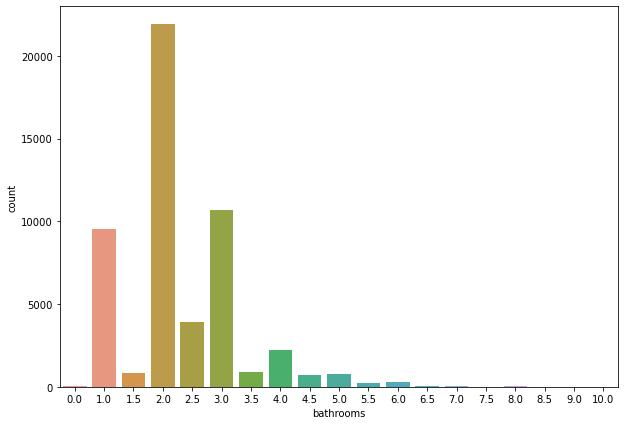

In [50]:
# Using a countplot to further investigate the distribution of the data

plt.figure(figsize=(10,7))
sns.countplot(x='bathrooms', data=houses)
plt.show()

**The bathrooms column is not really normally distributed**

**It contains a great number of outliers**

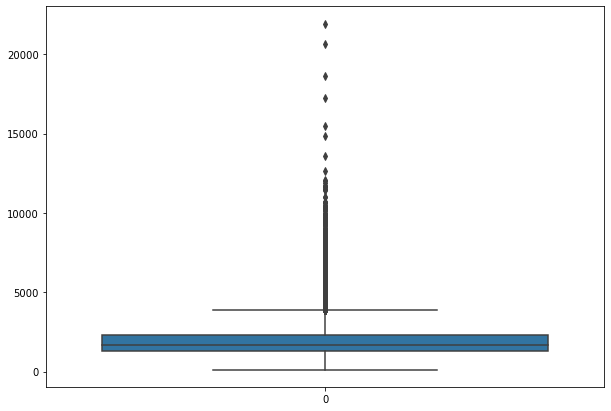

In [22]:
# Plotting data using a boxplot to understand distribution and see outliers

plt.figure(figsize=(10,7))
sns.boxplot(data=houses.indoor_sqft)
plt.show()

# There are lots of outliers in the indoor_sqft column

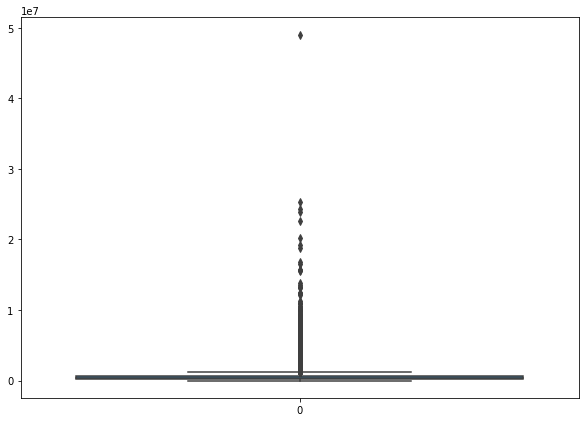

In [23]:
# Plotting data using a boxplot to understand distribution and see outliers

plt.figure(figsize=(10,7))
sns.boxplot(data=houses.tax_value)
plt.show()

# There are lots of outliers in the tax_value column but it is also the target variable so the current should be ok

## Takeaways of boxplot and countplot

- All the columns have a lot of outliers
- They are mostly normally distributed which will help with the statistical analysis
- Since my goal is to predict the tax value of most houses, I will remove what does not constitute 'most houses in the US'
- 0 bedroom and 0 bathroom do exist in the industry and it does not mean that the house does not have any or is not habitable
- .5, .25, .75 bathrooms exist as well and describe the existence of certain amenities in the bathroom like a tub or a sink...

## What data am I going t use?

- In the section below I am trying to determine what the cut off for the data is
- I will determine the proportions of each variable relating to the takeaways then apply it to the whole dataset

   * According to realtor.com, a mansion is in the real estate industry is a house that has 8,000 square feet and above.
   * I will cut off outliers that are 8,000 square feet and above.

In [24]:
# The proportion of houses that have 7_999 indoor_squarefeet and less

houses[houses.indoor_sqft <= 7_999].shape[0] / houses.shape[0]

0.99791821845337

In [25]:
# Mean of number of bedroooms of houses corresponding to less than 8_000 sqft

houses[houses.indoor_sqft <= 7_999].bedrooms.mean()

3.2996363636363637

In [26]:
# Mean of number of bathrooms of houses corresponding to less than 8_000 sqft

houses[houses.indoor_sqft <= 7_999].bathrooms.mean()

2.292124401913876

## Takeaways
- The proportion obtained are still significant and won't denature the data: 99.8%
- I will filter the data through the <= 7_999 square feet criterion

In [27]:
# Filtering the data through number of bedrooms

houses = houses[houses.indoor_sqft <= 7_999]
houses.head()

,bedrooms,bathrooms,indoor_sqft,tax_value
0,4,3.5,3100,1023282
1,2,1.0,1465,464000
2,3,2.0,1243,564778
3,4,3.0,2376,145143
4,4,3.0,2962,773303


In [28]:
# Verifying the state of the dataframe by checking number of null values,
# column and row numbers as well as data type

houses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52250 entries, 0 to 52441
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     52250 non-null  int64  
 1   bathrooms    52250 non-null  float64
 2   indoor_sqft  52250 non-null  int64  
 3   tax_value    52250 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 2.0 MB


In [29]:
# Checking the precentage of null values in the dataframe

houses.isnull().mean()

bedrooms       0.0
bathrooms      0.0
indoor_sqft    0.0
tax_value      0.0
dtype: float64

## General Takeaways for univariate exploration
- The median of the indoor_sqft column is toward the bottom 50% of the data
- The median of bedrooms and bathrooms columns are not visible
- The .describe() function shows that the median in probably toward the bottom 25% of the data
- The data still contains a fair number of outliers. I think that an appropriate scaler (Robust or Quantile) can handle that
- It is probable that a Standard scaler or a type of Robust Scaler (Robust or Quantile) would work best

****

# III. Scaling and Exploration

* Main questions:
    - What scaler is best for this dataset?
    - What variable affects the tax value column?
    - Which one does it the best?
    - Can I use one or all of the independent variables for my models?
    
**I will scale the data but assign the scaled data to a different variable than train and explore my train data with the train dataframe**

    - I will use Standard, Robust, and Quantile scalers
    - I will perform an exploration of the data to determine which columns are potential drivers of the tax value
    - For the exploration I will use appropriate charts and statistical tests to show that there is or there is not a correlation between the independent variables (bedrooms, bathrooms, and square footage) and tax value.

## A. Splitting and Scaling

**First I am going to split the data into train, validate, and test**

### 1. Splitting

### <font color = 'brown'>Train, Validate, and Test</font>

In [249]:
# Splits df into train_validate and test using train_test_split()
train_validate, test = train_test_split(houses, test_size=.2, random_state=175)

# splits train_validate into train and validate using train_test_split()
train, validate = train_test_split(train_validate, test_size=.3, random_state=175)

In [250]:
# Verifying the number of columns and rows in the split data (train, validate, and test)

train.shape

(29260, 4)

In [251]:
validate.shape

(12540, 4)

In [252]:
test.shape

(10450, 4)

### <font color = 'brown'>The y_train, y_validate, and y_test</font>

In [253]:
y_train = train.tax_value
y_validate = validate.tax_value
y_test = test.tax_value

In [256]:
# I will confirm that y_train is a series

y_train?
# y_train is indeed a series

### 2. Scaling

**Now I will create a dataframe that holds the features 'bedrooms', 'bathrooms', 'indoor_sqft' only**


In [157]:
# Creating a dataframe that holds the features 'bedrooms', 'bathrooms', 'indoor_sqft' only

for_scaling_train = train.drop(['tax_value'], axis=1)

for_scaling_train.head()

,bedrooms,bathrooms,indoor_sqft
47579,2,2.0,1313
48106,4,3.0,2629
31105,3,2.0,1648
12420,3,2.0,1580
16659,4,5.0,2547


In [158]:
# Creating a dataframe that holds the features 'bedrooms', 'bathrooms', 'indoor_sqft' only for the validate set

for_scaling_validate = validate.drop(['tax_value'], axis=1)

for_scaling_validate.head()

,bedrooms,bathrooms,indoor_sqft
21269,3,2.0,1321
14154,4,2.0,2299
12063,3,2.0,1550
22428,2,2.0,1296
13790,3,2.0,1848


In [159]:
# Creating a dataframe that holds the features 'bedrooms', 'bathrooms', 'indoor_sqft' only for the test set

for_scaling_test = test.drop(['tax_value'], axis=1)

for_scaling_test.head()

,bedrooms,bathrooms,indoor_sqft
26094,3,2.0,1425
43255,3,2.0,1342
8763,3,3.0,2994
39117,3,1.5,1150
48840,2,2.0,1411


**My next step is to create a Scaler Variable for each type of Scaler I am going to use (Standard, Robust, and Quantile)**

### <font color = 'brown'>Standard Scaler</font>

In [160]:
# Applying the standard scaler to the train data and fitting it

standard_scaler1 = sklearn.preprocessing.StandardScaler()

standard_scaler1.fit(for_scaling_train)

StandardScaler()

In [161]:
# Applying the standard scaler to the validate data and fitting it

standard_scaler2 = sklearn.preprocessing.StandardScaler()

standard_scaler2.fit(for_scaling_validate)

StandardScaler()

In [162]:
# Applying the standard scaler to the test data and fitting it

standard_scaler3 = sklearn.preprocessing.StandardScaler()

standard_scaler3.fit(for_scaling_test)

StandardScaler()

**I will now scale the data with Standard Scaler**

In [163]:
# Using Standard scaler to scale th data

X_train_standard = standard_scaler1.transform(for_scaling_train)
X_validate_standard = standard_scaler2.transform(for_scaling_validate)
X_test_standard = standard_scaler3.transform(for_scaling_test)

In [164]:
# Checking the shape and content of the X_train_standard to make sure it returns the expected array

X_train_standard

array([[-1.40188473, -0.29474639, -0.63235425],
       [ 0.75344444,  0.71329282,  0.76984155],
       [-0.32422014, -0.29474639, -0.27541231],
       ...,
       [-1.40188473, -0.29474639, -0.4064686 ],
       [ 0.75344444, -0.29474639, -0.58440683],
       [ 0.75344444,  0.71329282,  0.88384987]])

### <font color = 'brown'>**Robust Scaler**</font>

In [165]:
# Assigning Robust scaler to a variable and fitting it for train
robust_scaler1 = sklearn.preprocessing.RobustScaler()

robust_scaler1.fit(for_scaling_train)

RobustScaler()

In [166]:
# Assigning Robust scaler to a variable and fitting it for validate
robust_scaler2 = sklearn.preprocessing.RobustScaler()

robust_scaler2.fit(for_scaling_validate)

RobustScaler()

In [167]:
# Assigning Robust scaler to a variable and fitting it for test
robust_scaler3 = sklearn.preprocessing.RobustScaler()

robust_scaler3.fit(for_scaling_test)

RobustScaler()

In [168]:
# Applying the robust scaler to the train data

X_train_robust = standard_scaler1.transform(for_scaling_train)
X_validate_robust = standard_scaler2.transform(for_scaling_validate)
X_test_robust = standard_scaler3.transform(for_scaling_test)

In [169]:
# Checking the shape and content of the X_train_robust to make sure it returns the expected array

X_train_robust

array([[-1.40188473, -0.29474639, -0.63235425],
       [ 0.75344444,  0.71329282,  0.76984155],
       [-0.32422014, -0.29474639, -0.27541231],
       ...,
       [-1.40188473, -0.29474639, -0.4064686 ],
       [ 0.75344444, -0.29474639, -0.58440683],
       [ 0.75344444,  0.71329282,  0.88384987]])

### <font color = 'brown'>**Quantile Scaler**</font>

In [170]:
# Assigning Quantile scaler to a variable and fitting it for train
quantile_scaler1 = sklearn.preprocessing.QuantileTransformer()

quantile_scaler1.fit(for_scaling_train)

QuantileTransformer()

In [171]:
# Assigning Quantile scaler to a variable and fitting it for validate
quantile_scaler2 = sklearn.preprocessing.QuantileTransformer()

quantile_scaler2.fit(for_scaling_validate)

QuantileTransformer()

In [172]:
# Assigning Quantile scaler to a variable and fitting it for test
quantile_scaler3 = sklearn.preprocessing.QuantileTransformer()

quantile_scaler3.fit(for_scaling_test)

QuantileTransformer()

In [173]:
# Applying the quantile scaker to the train data

X_train_quantile = quantile_scaler1.transform(for_scaling_train)
X_validate_quantile = quantile_scaler2.transform(for_scaling_validate)
X_test_quantile = quantile_scaler3.transform(for_scaling_test)

In [174]:
# Checking the shape and content of the train_scaled_standard to make sure it returns the expected array

X_train_quantile

array([[0.09159159, 0.40990991, 0.28228228],
       [0.76476476, 0.7957958 , 0.82802803],
       [0.3953954 , 0.40990991, 0.49572489],
       ...,
       [0.09159159, 0.40990991, 0.42192192],
       [0.76476476, 0.40990991, 0.31131131],
       [0.76476476, 0.7957958 , 0.84704008]])

**After finishing all these splits and scalers I realized that I don't need all of them for my MVP so I will choose just one for my MVP and come back to the others if I have enough time**

## B. Exploration on unscaled data

## Bedrooms column

**Hypothesis setting**
- Null hypothesis: $H_{0}$: there is no correlation between the number of bedrooms and the tax value of the properties


- Alternative hypothesis: $H_{A}$: there is a correlation between the number of bedrooms and the tax value of the properties.

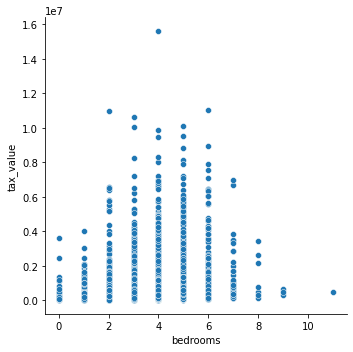

In [66]:
# Plotting a scatter plot to visualize the existence or not of a correlation before running a statistical test

sns.relplot(x='bedrooms', y='tax_value', data=train)
plt.show()

<AxesSubplot:xlabel='bedrooms', ylabel='tax_value'>

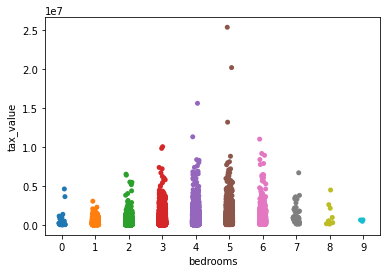

In [59]:
# Using a stripplot to further investigate the data

sns.stripplot(x='bedrooms', y='tax_value', data=train)

* Observations
    - The scatter plot and the strip plot display slightly different distribution of the data
        - 11 bedroom outlier missing in strip plot
        - outliers better represented
        - I would rather use the information from the scatter plot
    - As the number of bedrooms go from 0 to 7, I notice that there is an increase of the tax value af the properties
    - A great number of properties (with 0 to 11 bedrooms) have their prices conglomerated between the tax value of 0.0 and 0.6*10^7
    - The number of bedrooms is not always synonnymous of greater tax value
    - There is a 4 bedroom property that has a tax value far greater than all the other properties
    - Overall there doesn't seem to be a very strong linear relationship between the two series

* Action
    - Perform statistical analyses to determine the correlation between the two variables (the shape of the chart and the nature of the data hints towards a Spearman test but I'll start with a Pearson first)

In [62]:
# I'll perform a Pearson test first to see the the level of correlation

bedrooms_pearsonr = stats.pearsonr(train.bedrooms, train.tax_value)
r, p = bedrooms_pearsonr

print(f'r is {r:.3f}')
print(f'p is {p:.10f}')

r is 0.262
p is 0.0000000000


<font color = 'brown'>**There is correlation because the p value is 0 up to 10 decimals and I can reject the null hypothesis. However, r is low = 0.26 meaning that 26% of the variation is explained by the relationship Bedrooms/Tax value. This does not surprise me because tax value goes up, then down, and remain the same in some case while bedrooms goes up**</font>

I will perform a spearman test to further investigate but the shape of the graph tells me <font color = 'brown'>**I may need a Hoeffding D test**</font> as well but I will leave it for later if I have time

In [63]:
# Performing a Spearman test to further investigate the correlation between bedrooms and tax value

bedrooms_spearmanr = stats.spearmanr(train.bedrooms, train.tax_value)
r, p = bedrooms_spearmanr

print(f'r is {r:.3f}')
print(f'p is {p:.10f}')

r is 0.296
p is 0.0000000000


<font color = 'brown'>**There is correlation because the p value is 0 up to 10 decimals and I can reject the null hypothesis. However, r is low = 0.29 meaning that 29% of the variation is explained by the relationship Bedrooms/Tax value. This does not surprise me because tax value goes up, then down, and remain the same in some case while bedrooms goes up**</font>

## Bathrooms column

**Hypothesis setting**
- Null hypothesis: $H_{0}$: there is no correlation between the number of bathrooms and the tax value of the properties


- Alternative hypothesis: $H_{A}$: there is a correlation between the number of bathrooms and the tax value of the properties.

In [284]:
# Alpha is set at 0.5 for comparison with the p-value
alpha = .05

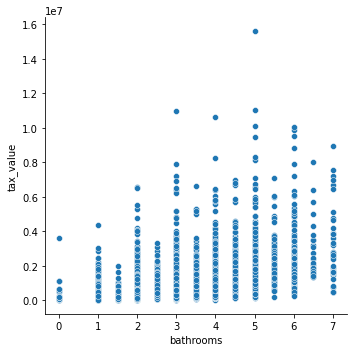

In [83]:
# Plotting a scatter plot to visualize the existence or not of a correlation before running a statistical test

sns.relplot(x='bathrooms', y='tax_value', data=train)
plt.show()

<AxesSubplot:xlabel='bathrooms', ylabel='tax_value'>

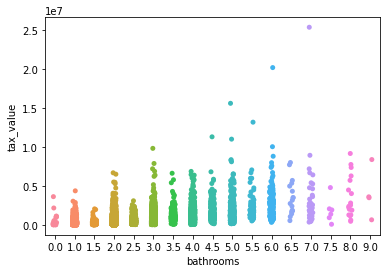

In [60]:
# Using a stripplot to further investigate the data

sns.stripplot(x='bathrooms', y='tax_value', data=train)

* Observations
    - Here too the scatter plot performs better. I will use it instead
    - The correlation seems stronger here because it mostly goes up except for a few outliers
    - One constant is that up to a certain tax value, about 0.3, there are houses with 0 to 7 bathrooms except for 6.5 bathrooms
    - There are no houses with 0.5 bathrooms
* Action
    - Perform a Pearson then a Spearman analysis to test for correlation

In [64]:
# I'll perform a Pearson test first to see the level of correlation

bathrooms_pearsonr = stats.pearsonr(train.bathrooms, train.tax_value)
r, p = bathrooms_pearsonr

print(f'r is {r:.3f}')
print(f'p is {p:.10f}')

r is 0.513
p is 0.0000000000


<font color = 'brown'>**There is correlation and I can reject the null hypothesis because the p value is 0 up to 10 decimals. The r value is twice as high here = 0.5**</font>

I will perform a spearman test to further investigate it

In [85]:
# Performing a Spearman test to see what insight it can provide

bathrooms_spearmanr = stats.spearmanr(train.bathrooms, train.tax_value)
r, p = bathrooms_spearmanr

print(f'r is {r:.3f}')
print(f'p is {p:.10f}')

r is 0.486
p is 0.0000000000


<font color = 'brown'>**There is correlation and I can reject the null hypothesis because the p value is 0 up to 10 decimals. The r value is lower than that of the Pearson one**</font>

I will consider the Pearson test result

## Indoor square footage column

**Hypothesis setting**
- Null hypothesis: $H_{0}$: there is no correlation between the indoor square footage and the tax value of the properties


- Alternative hypothesis: $H_{A}$: there is a correlation between the indoor square footage and the tax value of the properties.

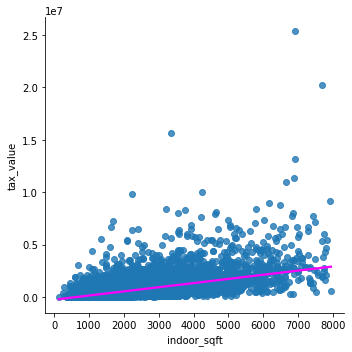

In [271]:
# Plotting a scatter plot to visualize the existence or not of a correlation before running a statistical test

sns.lmplot(x='indoor_sqft', y='tax_value', data=train, line_kws={'color': '#FF00FF'})
plt.show()

* Observations
    - There is a general upward tendency of the data with the with outliers here as well
    - The clustering of the data at the bottom of the graph (around y=tax_value= ~0.3) is still present
* Actions
    - Perform a Pearson then if necessary a Spearman analysis to test for correlation

In [65]:
# I'll perform a Pearson test first to see the level of correlation

indoor_sqft_pearsonr = stats.pearsonr(train.indoor_sqft, train.tax_value)
r, p = indoor_sqft_pearsonr

print(f'r is {r:.3f}')
print(f'p is {p:.10f}')

r is 0.582
p is 0.0000000000


<font color = 'brown'>**There is correlation and I can reject the null hypothesis because the p value is 0 up to 10 decimals. The r value is higher here = 0.6**</font>

I will perform a spearman test to further investigate it

In [66]:
# Performing a Spearman test to see what insight it can provide
# but from the shape of the data, I think it won't be more relevant

indoor_sqft_spearmanr = stats.spearmanr(train.indoor_sqft, train.tax_value)
r, p = indoor_sqft_spearmanr

print(f'r is {r:.3f}')
print(f'p is {p:.10f}')

r is 0.529
p is 0.0000000000


<font color = 'brown'>**There is correlation and I can reject the null hypothesis because the p value is 0 up to 10 decimals. The r value is lower than that of the Pearson one**</font>

I will consider the Pearson test result

### General Takeaways of Statistical Analysis
- There is a correlation between all the 3 columns bedrooms, bathrooms,  and indoor_sqft and tax_value
- indoor_sqft seems to have the strongest correlation
- I can move forward with modeling with all three variables

## General Takeaways of Scaling, Visualization and Statistical Analysis

* Answers:
    - The best scalers in my opinion are the ones that are not influenced by the outliers aka Standard, Robust and Quantile
    - All of the variables in the dataset affect the tax value column
    - indoor_sqft affects it the most
    - I can use all of the independent variables for my models

****

# IV. Modeling

* Question: Which model is the best at predicting properties assessed values?

    - Examine the shape of the tax value column to determine what model would work best
    - Determine a baseline that will be used to compare the the models I will be creating
    - Create an OLS, a LassoLars with alpha=3, and a Tweedie Regressor with power=1 & 3 and alpha=3
    - Run the models on validate as well
    - Compute an RMSE for each model and its validate and compare them all
    - Choose the best model and run it on the test dataset

## A. Data shape

**I will plot my data again to have a fresh view of it then I will choose the model(s) I think would best perform**

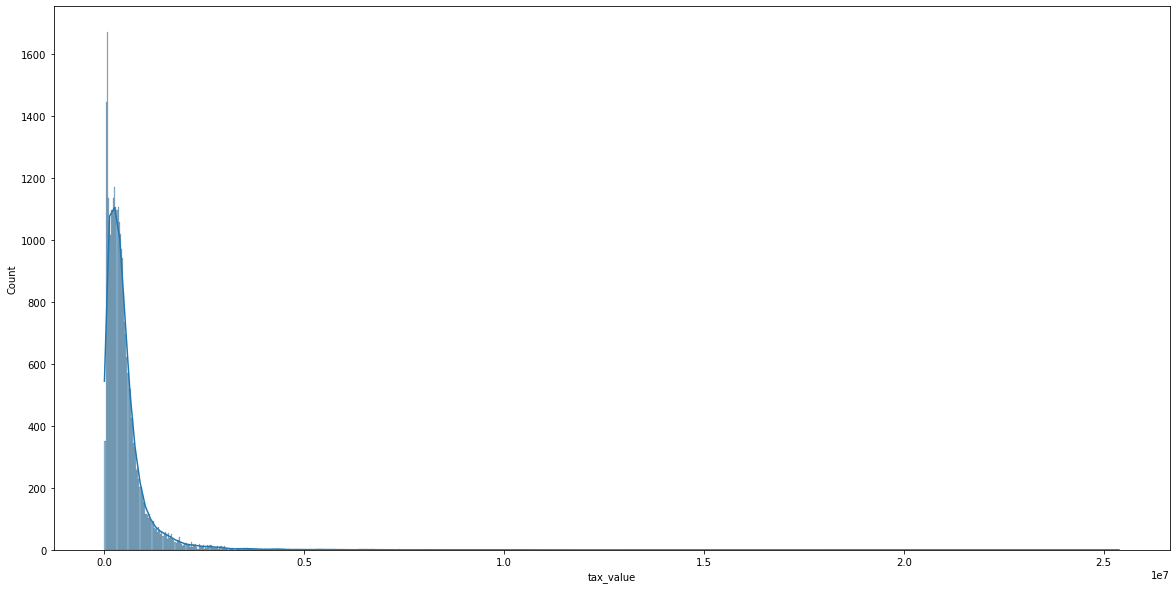

In [282]:
# Plotting a histogram with the approximation of the shape of the distribution

plt.figure(figsize=(20, 10))
sns.histplot(train.tax_value, kde=True)
plt.show()

### * Observations
    - Tax_value does not really have a normal distribution and has a lot of outliers
    - It looks more like an inverse gaussian distribution or a poisson distribution
### * Actions
    - Because of the shape of the distribution, when I run the Tweedie model, I will use the power at 1 and 3

## B. Modeling

### 1. Baseline

**I will establish the baseline through the mean and the median and compare**

**My hypothesis is that median would work best because there is a lot of outliers in y_train**

In [257]:
# I will set y_train and y_validate as dataframe first

y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

In [258]:
# I will confirm that y_train has become a dataframe

y_train?
# y_train has become a dataframe

In [259]:
# I will confirm that y_validate has become a dataframe

y_validate?
# y_validate has become a dataframe

In [260]:
# I will confirm that y_test has become a dataframe

y_test?
# y_test has become a dataframe

In [154]:
# Computing tax_value median

tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

In [155]:
# Computing tax_value mean

tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

**Evaluating the baseline**

In [146]:
# Calculating RMSE for median

rmse_train_median = math.sqrt(mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median))
rmse_validate_median = math.sqrt(mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median))

print('RMSE using the median\nTrain: ', rmse_train_median, '\nValidate: ', rmse_validate_median)

RMSE using the median
Train:  654028.5169540899 
Validate:  619700.2305704806


In [147]:
# Calculating RMSE for mean

rmse_train_mean = math.sqrt(mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean))
rmse_validate_mean = math.sqrt(mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean))

print('RMSE using the mean\nTrain: ', rmse_train_mean, '\nValidate: ', rmse_validate_mean)

RMSE using the mean
Train:  638024.3698355088 
Validate:  602948.5814780932


### Baseline Takeaways
    - The RMSE for the median is higher than the RMSE for the mean. To my surprise, the RMSE for the mean has a better fit than that of the median
    - I will use the mean as a baseline

## 2. Modeling

**I will be modeling on the Standard Scaler first, then on the Robust one, and if still not satisfactory, I will try the Quantile Scaler to finish**

**I will use the OLS model, the LASSO+LARS model and the Polynomial Regression model**

### <font color = 'brown'>**OLS Model with X_train_standard, Standard Scaler**</font>

In [175]:
# Creating the model object
lm = LinearRegression(normalize=True)

# Fitting the model to training data
lm.fit(X_train_standard, y_train.tax_value)

# Making prediction on the train set
y_train['tax_value_predicted'] = lm.predict(X_train_standard)

# Displaying the y_train
y_train.head()

,tax_value,tax_value_pred_median,tax_value_pred_mean,tax_value_predicted
47579,629682,370998.0,514797.1811,430742.893627
48106,183245,370998.0,514797.1811,771514.457988
31105,564365,370998.0,514797.1811,426475.611930
12420,105997,370998.0,514797.1811,399158.891178
16659,854982,370998.0,514797.1811,918168.267727


In [177]:
# Making predictions on the validate set

y_validate['tax_value_predicted'] = lm.predict(X_validate_standard)

In [186]:
# Evaluating rmse_train and rmse_validate modeled on Standard Scaler

rmse_train = math.sqrt(mean_squared_error(y_train.tax_value, y_train.tax_value_predicted))
rmse_validate = math.sqrt(mean_squared_error(y_validate.tax_value, y_validate.tax_value_predicted))

print('RMSE using OLS scaled on Standard Scaler Model\n\nTrain: ', rmse_train,
      '\nValidate: ', rmse_validate)

RMSE using OLS scaled on Standard Scaler

Train:  509464.22684402234 
Validate:  485529.30834429775


### Takeaways of OLS scaled on Standard Scaler modeling
- The OLS model beats the mean baseline model by a fair amount both on the train and on the validate data
    * RMSE using the mean
        - Train:  638024.37 
        - Validate:  602948.58
    * RMSE OLS using LinearRegression
        - Train:  509464.23
        - Validate:  485529.31
- I will run the next model

### <font color = 'brown'>**LassoLars Model with X_train_standard, Standard Scaler**</font>

In [189]:
# Creating model object
lars = LassoLars(alpha=3.0)

# Fitting the model to training data
lars.fit(X_train_standard, y_train.tax_value)

# Making prediction on the train set
y_train['tax_value_predicted2'] = lars.predict(X_train_standard)

# Displaying the y_train
y_train.head()

,tax_value,tax_value_pred_median,tax_value_pred_mean,tax_value_predicted,tax_value_predicted2
47579,629682,370998.0,514797.1811,430742.893627,429319.153398
48106,183245,370998.0,514797.1811,771514.457988,771479.819110
31105,564365,370998.0,514797.1811,426475.611930,426436.723538
12420,105997,370998.0,514797.1811,399158.891178,399176.535972
16659,854982,370998.0,514797.1811,918168.267727,916514.727101


In [190]:
# Making predictions on the validate set
y_validate['tax_value_predicted2'] = lars.predict(X_validate_standard)

In [211]:
# Evaluating rmse_train and rmse_validate modeled on Standard Scaler
rmse_train_lars = math.sqrt(mean_squared_error(y_train.tax_value, y_train.tax_value_predicted2))
rmse_validate_lars = math.sqrt(mean_squared_error(y_validate.tax_value, y_validate.tax_value_predicted2))

print('RMSE using the LassoLars with alpha=3.0\n\nTrain: ', rmse_train_lars, 
      '\nValidate: ', rmse_validate_lars)

RMSE using the LassoLars with alpha=3.0

Train:  509465.8186062523 
Validate:  485499.85689349583


### Takeaways of LassoLars Model scaled on Standard Scaler modeling
- The LassoLars model beats the mean baseline model by a fair amount both on the train and validate data
- It also beats the OLS by a small margin on the validate but looses by a little less than $2 on the train
    * RMSE using the mean
        - Train:  638024.37 
        - Validate:  602948.58
    * RMSE OLS using LinearRegression
        - Train:  509464.23
        - Validate:  485529.31
    * RMSE using LassoLars
        - Train: 509465.82
        - Validate: 485499.86
- I will run the next model

### <font color = 'brown'>**Tweedie Regressor (GLM) Model with X_train_Standard, Standard Scaler**</font>

In [219]:
# Creating model object with power at 3 because
# the tax value distribution looks more like an inversed gaussian distribution
glm = TweedieRegressor(power=1, alpha=3.0)

# Fitting the model to training data
glm.fit(X_train_standard, y_train.tax_value)

# Making prediction on the train set
y_train['tax_value_predicted3'] = glm.predict(X_train_standard)


# Displaying the y_train
y_train.head()

,tax_value,tax_value_pred_median,tax_value_pred_mean,tax_value_predicted,tax_value_predicted2,tax_value_predicted3
47579,629682,370998.0,514797.1811,430742.893627,429319.153398,403030.710326
48106,183245,370998.0,514797.1811,771514.457988,771479.819110,611030.276579
31105,564365,370998.0,514797.1811,426475.611930,426436.723538,399943.410258
12420,105997,370998.0,514797.1811,399158.891178,399176.535972,389680.431159
16659,854982,370998.0,514797.1811,918168.267727,916514.727101,856538.561999


In [208]:
# Making predictions on the validate set

y_validate['tax_value_predicted3'] = glm.predict(X_validate_standard)

In [214]:
# Evaluating rmse_train and rmse_validate modeled on Standard Scaler

rmse_train_glm = math.sqrt(mean_squared_error(y_train.tax_value, y_train.tax_value_predicted3))
rmse_validate_glm = math.sqrt(mean_squared_error(y_validate.tax_value, y_validate.tax_value_predicted3))

print('RMSE using Tweedie Regressor, power=1 & alpha=3.0\n\nTrain: ', rmse_train_glm, 
      '\nValidation: ', rmse_validate_glm)

RMSE using Tweedie Regressor, power=1 & alpha=3.0

Train:  509711.5741323715 
Validation:  487872.87596042734


### Takeaways of Tweedie Regressor Model scaled on Standard Scaler modeling
- The Tweedie Regressor model beats the mean baseline model by a fair amount both on the train and validate data
- However, it does not beat the OLS or the  LassoLars
    * RMSE using the mean
        - Train:  638024.37 
        - Validate:  602948.58
    * RMSE OLS with a Linear Regression
        - Train:  509464.23
        - Validate:  485529.31
    * RMSE using LassoLars
        - Train: 509465.82
        - Validate: 485499.86
    * RMSE using Tweedie Regressor
        - Train: 509711.57
        - Validate: 487872.87
- I will use the LassoLars because it performed slightly better on unseen data (validate) than the OLS model

## <font color = 'brown'>**LassoLars Model with X_train_standard, Standard Scaler running on test dataset**</font>

In [264]:
# Making predictions on the test set

y_test['tax_value_predicted2'] = lars.predict(X_test_standard)

# Evaluating rmse_test modeled on Standard Scaler for LassoLars
rmse_test_lars = math.sqrt(mean_squared_error(y_test.tax_value, y_test.tax_value_predicted2))

print('RMSE using the LassoLars with alpha=3.0 on test dataset\n\nTest: ', rmse_test_lars)

RMSE using the LassoLars with alpha=3.0 on test dataset

Test:  491929.3710342825


In [267]:
# Improvement from baseline

a = ((491929.37-602948.58)/602948.58)*100
a

-18.412716056151915

In [ ]:
# Plotting the model and the baseline

plt.hist(y_train.tax_value_predicted2, color='blue', alpha=.5, label="Actual Final Grades")
plt.hist(y_train.G3_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Final Grades - Mean")
plt.xlabel("Final Grade (G3)")
plt.ylabel("Number of Students")
plt.legend()
plt.show()


## Modeling takeaways
- The Tweedie regression seems to work best with Min-Max Scaler at power=3 but is of at power=1
- The OLS and LassoLars are very close in results
- Changing scaling does not impact the result if different scalers are applied to the same model
- The LassoLars is the best model by a very small margin against OLS

****

## Conclusions

- The LassoLars model turned out to be the one that pedicts the best what property prices are going to be based on the data I used.

- However, as we saw, the model has a margin of error going up to $491929.37. This is a margin that will not help most of our customer let alone us since we are looking to optimize sale prices.

- Percentage improvement from baseline 18.41%

- I will discuss the consequence of such findings in my recommendations and Next Steps rubric 

****

## Key findings

- Using bedrooms number, bathroom number and indoor square footage helps predict the assessed prices of properties but it is not enough. below is the order of importance:
    - indoor_sqft
    - then bathrooms and bedrooms
    - This may suggest that clients are interested in size of course but most importantly amenities in the bathrooms but I am not categorical on that
- Time doesn't seem to have an impact on the the general distribution of prices (this is why I dropped it)
- The relation between the number of bedrooms and bathrooms on one side and the assessed value of the properties is interesting because it seems that to a certain extent the number of bedrooms and to a slightly lesser extent the number of bathrooms does not matter. That would mean that more is better to a certain extent.

-  The relationship between the independent variables and the dependent one is not very strong hinting to the fact that there are probably more elements to that relationship

## Recommedations

**I will recommend that the collection of the data process be streamlined to provide more accurate datasets**

**A bit of time be allocated to deepening the work on those models**

## Next Steps, and other additions

- The next step would be to run better models (this would be part of what I would do if I had more time):
    * by including more variables after determining their relevance
    * by using the Min-Max scaler for the power=3-Tweedie Regressor and the others to see if it makes a difference
    * by examining the reason why some of the houses have the same price no matter the number of bedrooms or batrooms they have
    * examining what the difference is between houses with the same characteristics
- Then, we can use the information from that analysis to further determine what data we should gather or should not gather
- Improve the data collection process